In [73]:
import pdbufr
import sys
import traceback
 
from math import isnan

import plotly.express as px
from shapely.geometry import LineString

from ipywidgets import interact
import os
import birdy
import geopandas as gpd
import pandas as pd
from datetime import datetime, timedelta
import ipyleaflet
import ipywidgets as widgets

from Magics import macro as magics
from IPython.display import display
from Magics.macro import *

import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Function to import storms file and load it in a dataframe
def create_storms_df():
    # Load cyclone dataframe with Mean sea level pressure value
    df_storms = pdbufr.read_bufr("trials/track_data/tc_test.bufr",
        columns=("stormIdentifier", "ensembleMemberNumber", "latitude", "longitude",
                 "pressureReducedToMeanSeaLevel"))
    # Load cyclone dataframe with Wind speed at 10m value
    df1 = pdbufr.read_bufr("trials/track_data/tc_test.bufr",
        columns=("stormIdentifier", "ensembleMemberNumber", "latitude", "longitude",
                 "windSpeedAt10M"))
    # Add the Wind speed at 10m column to the storms dataframe 
    df_storms["windSpeedAt10M"] = df1.windSpeedAt10M
    # Storms with number higher than 10 are not real storms (according to what Fernando said)
    drop_condition = df_storms.stormIdentifier < '11'
    df_storms = df_storms[drop_condition]
    return df_storms

df_storms = create_storms_df()
# Drop NaN in latitude and longitude columns
df_storms.dropna(subset = ['latitude', 'longitude'], inplace=True)

In [30]:
## SAVE EACH ENSEMBLE TRACK IN A DIFFERENT .CSV FILE ##

storms = df_storms.stormIdentifier.unique()

for storm in storms:
    df_cyclone = df_storms[df_storms.stormIdentifier == storm]
    
    # create folder for the trajectories of the cyclone
    folder = "data/" + storm + "/"
    try:
        os.makedirs(folder)
    except:
        print(f'Folder {folder} already existing')
    
    # Save .csv file for each ensemble track
    ensembles = df_cyclone.ensembleMemberNumber.unique()
    for ensemble in ensembles:
        filename = folder + 'trajectory_%.02d.csv' % ensemble
        df_track = df_cyclone[df_cyclone.ensembleMemberNumber == ensemble]
        df_track.drop(columns=['stormIdentifier', 'ensembleMemberNumber'], inplace=True)
        df_track.to_csv(filename, index=False)

Folder data/08W/ already existing


In [94]:
## FUNCTION TO PLOT ALL THE ENSEMBLE TRACKS OF A CYCLONE ##
# .csv files must be saved already

def plot_ensemble_tracks(cyclone_n, bottom, up, left, right):
    
    toplot = []
    # settings of the geographical area
    area = mmap(
        subpage_map_projection="cylindrical",
        subpage_lower_left_longitude=left,
        subpage_lower_left_latitude=bottom,
        subpage_upper_right_longitude=right,
        subpage_upper_right_latitude=up,
    )
    toplot.append(area)
    
    # settings of the coastline
    coast = mcoast(
        map_coastline_land_shade = "on",
        map_coastline_land_shade_colour = "cream",
        map_coastline_sea_shade = "on",
        map_coastline_sea_shade_colour = "#70CEE2",
        # map_cities = "on",
        map_grid_line_style = "dash",
        map_grid_colour = "black",
        map_label = "on",
        map_label_colour = "brown",
        map_coastline_colour = "brown",
    )
    toplot.append(coast)
    
    # settings of the tracks 
    colours = ["red", "blue", "green", "yellow", "purple", "orange", "cyan", "black" ]
    colour = 0

    for i in range(1,52):

        file = f"data/{cyclone_n}/trajectory_%02d.csv" % i

        data = mtable(
            table_filename = file,
            table_variable_identifier_type='index',
            table_latitude_variable = "1",
            table_longitude_variable = "2",
            table_value_variable = "3",
            table_header_row = 1,
        )

        line=msymb(
            symbol_type='marker',
            symbol_marker_index = 28,
            symbol_colour = colours[colour],
            symbol_height = 0.20,
            symbol_text_font_colour = "black",       
            symbol_connect_line ='on'
        )

        colour += 1
        if colour == len(colours):
            colour = 0

        toplot.append(data)
        toplot.append(line)
    
    title = mtext(
        text_lines= [f"<font colour='navy'> {cyclone_n} ensemble trajectories </font>"],
        text_justification= 'centre',
        text_font_size= 1.,
        text_font_style= 'bold',
        text_mode='title',
    )
    toplot.append(title)
    
    display(plot(toplot))

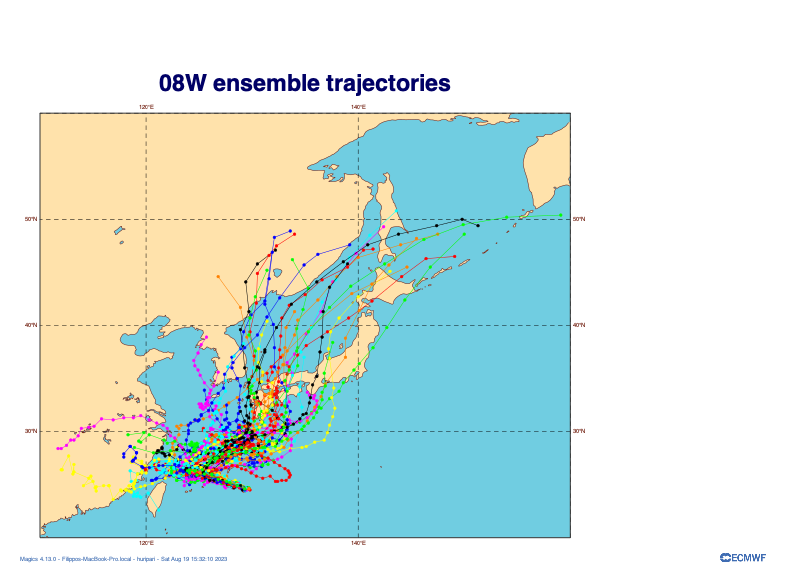

In [88]:
plot_ensemble_tracks('08W', 20, 60, 110, 160)

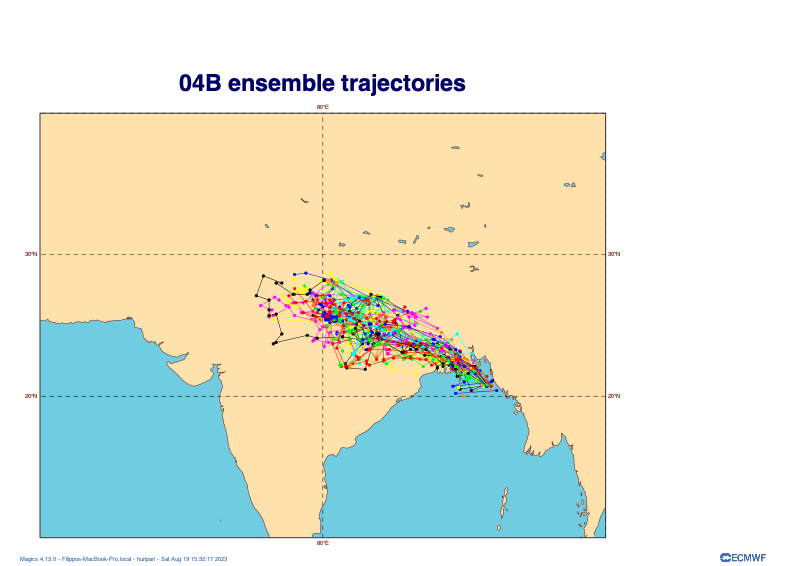

In [89]:
plot_ensemble_tracks('04B', 10, 40, 60, 100)

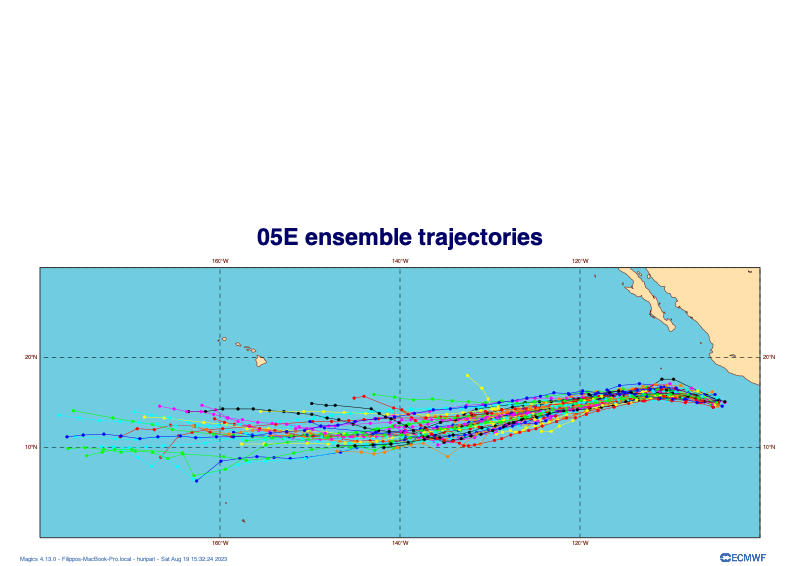

In [90]:
plot_ensemble_tracks('05E', 0, 30, -180, -100)

In [101]:
## DEFINE WIDGETS FOR INTERACTIVE MAP ##

# Cyclone dropdown selection
storms = df_storms.stormIdentifier.unique()
cyclone = widgets.Dropdown(
    options = storms.tolist(),
    description = 'Active Storms:',
    disabled=False,
)
cyclone.style.description_width = '90px'

display(cyclone)

# Longitude slider
longitude = np.arange(-180,185,5)
longitude_slider = widgets.SelectionRangeSlider(
    options=longitude,
    index=(0, len(longitude)-1),
    description='Longitude:',
    orientation='horizontal',
    layout={'width': '400px'},
    disabled=False,
)

longitude_slider.style.description_width = '100px'
longitude_slider.style.handle_color = 'lightgreen'

display(longitude_slider)

# Latitude slider
latitude = np.arange(-90,95,5)
latitude_slider = widgets.SelectionRangeSlider(
    options=latitude,
    index=(0, len(latitude)-1),
    description='Latitude:',
    orientation='vertical',
    layout={'width': '400px'},
    disabled=False,
)

latitude_slider.style.description_width = '100px'
latitude_slider.style.handle_color = 'lightgreen'

display(latitude_slider)

Dropdown(description='Active Storms:', options=('04B', '05E', '08W'), style=DescriptionStyle(description_width…

SelectionRangeSlider(description='Longitude:', index=(0, 72), layout=Layout(width='400px'), options=(-180, -17…

SelectionRangeSlider(description='Latitude:', index=(0, 36), layout=Layout(width='400px'), options=(-90, -85, …

In [104]:
widgets.interactive(plot_ensemble_tracks, cyclone_n=cyclone, bottom=latitude_slider.value[0], up=latitude_slider.value[1], 
                    left=longitude_slider.value[0], right=longitude_slider.value[1])

interactive(children=(Dropdown(description='Active Storms:', options=('04B', '05E', '08W'), style=DescriptionS…

In [113]:
## DEFINE DIFFERENT WIDGETS FOR LONGITUDE AND LATITUDE ##

# Bottom boundary
btm_lat = widgets.IntSlider(
    value=-40,
    min=-90,
    max=90,
    step=5,
    description='Bottom:',
    disabled=False,
    orientation='horizontal',
)
btm_lat.style.handle_color = 'lightgreen'

# Up boundary
up_lat = widgets.IntSlider(
    value=40,
    min=-90,
    max=90,
    step=5,
    description='Up:',
    disabled=False,
    orientation='horizontal',
)
up_lat.style.handle_color = 'lightgreen'

# Left boundary
sx_lon = widgets.IntSlider(
    value=-90,
    min=-180,
    max=180,
    step=5,
    description='Left:',
    disabled=False,
    orientation='horizontal',
)
sx_lon.style.handle_color = 'lightgreen'

# Right boundary
dx_lon = widgets.IntSlider(
    value=90,
    min=-180,
    max=180,
    step=5,
    description='Right:',
    disabled=False,
    orientation='horizontal',
)
dx_lon.style.handle_color = 'lightgreen'

In [114]:
widgets.interactive(plot_ensemble_tracks, cyclone_n=cyclone, bottom=btm_lat, up=up_lat, left=sx_lon, right=dx_lon)

interactive(children=(Dropdown(description='Active Storms:', options=('04B', '05E', '08W'), style=DescriptionS…